In [2]:
# !pip install -r requirements.txt
# !pip install timm

In [3]:
import fastcore.all as fc
import fastcore.test as test
from torch import nn
import torch, timm, torchvision
from torchvision import transforms
import torch.nn.functional as F

In [29]:
from torch.utils.data import DataLoader


class Dataset():
    def __init__(self, x, y):
        self.x, self.y = x, y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        return self.x[i], self.y[i]


def get_dataLoaders(train_ds, valid_ds, bs, **kwards):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwards), DataLoader(valid_ds, batch_size=bs*2, **kwards))


def accuracy(out, y):
    return (out.argmax(dim=1) == y).float().mean()


# -------------------------------------------------------------------------------------------------------------------------


import torch
from typing import Mapping
import numpy as np
import math,torch,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy
from torch import optim
import torch.nn.functional as F
import matplotlib as mpl
from torch import nn, tensor
from datasets import load_dataset
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics.aggregation import MeanMetric
from operator import itemgetter
from torch.utils.data import default_collate
from fastprogress import progress_bar, master_bar


def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f


def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b):
        return get(default_collate(b))
    return _f


class DataLoaders:
    def __init__(self, train_data_loader, valid_data_loader):
        self.train = train_data_loader
        self.valid = valid_data_loader

    @classmethod # static method
    def from_datasetDict(cls, datasetDict, batch_size): #, as_tuple=True):
        '''
        static method with cls allows the instanciation of the class: calls self.__init__
        May use multiple workers
        Do not send anything to device here cuz huge overload
        '''
        return cls(*[DataLoader(ds, batch_size, collate_fn=collate_dict(ds)) for ds in datasetDict.values()])


def to_cpu(x): # optional here it was used because torchmetrics was bugged
    if isinstance(x, Mapping):
        return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list):
        return [to_cpu(o) for o in x]
    if isinstance(x, tuple):
        return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype==torch.float16 else res

def to_device(x, device=None):
    if device is None:
        device = 'cuda'
    if isinstance(x, Mapping):
        return {k:v.to(device) for k,v in x.items()}
    return type(x)(o.to(device) for o in x)



class Callback(): order = 0
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass


class TrainCB(Callback):
    '''
    Implements training details for a Multiclass Classification model
    Could implement training details for other tasks

    n_inp = number of inputs to the model eg DDPM take 2 inputs: the image and the timestamp t
    '''
    def __init__(self, n_inp=1):
        self.n_inp = n_inp

    def predict(self, learn):
        '''given the return of the collate fnc feed to the nn the els up to the n_inp els'''
        learn.preds = learn.model(*learn.batch[:self.n_inp])

    def get_loss(self, learn):
        '''given the return of the collate fnc, use from the n_inp els onward as targets'''
        learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])

    def backward(self, learn):
        learn.loss.backward()

    def step(self, learn):
        learn.opt.step()

    def zero_grad(self, learn):
        learn.opt.zero_grad()


class MetricCB(Callback):
    '''
    Stores all metrics to be used/computed by model.
    Unique access point/handler to compute all metrics requested.
    '''
    def __init__(self, *ms, **metrics):
        '''
        *ms = list of positional non-keyworded inputs
        **metrics = dict of keyworded inputs

        You can construct as:
            metric = MetricCB(MulticlassAccuracy(n_classes))
        or:
            metric = MetricCB(accuracy=MulticlassAccuracy(n_classes))

        in the first case *ms will contain: MulticlassAccuracy and by taking its name stores it in metrics dict
        in the second case **metrics dict will contain {'accuracy'= MulticlassAccuracy()}
        '''
        for o in ms:
            metrics[type(o).__name__] = o  # adds non-keyworded inputs to **metrics
        self.metrics = metrics # store **metrics dict
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = MeanMetric() # MeanMetric() added by default

    def _log(self, d):
        # override for more complex formatting
        print(d)

    def before_fit(self, learn):
        '''
        !Important: this method sets this MetricCB obj in calling learner
        '''
        learn.metrics = self

    def before_epoch(self, learn):
        [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k: f'{v.compute():.3f}' for k,v in self.all_metrics.items()} # compute all metrics
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn): # creates dict for printing/logging
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values():
            m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))


class DeviceCB(Callback):
    def __init__(self, device=None):
        if device is None:
            device = 'cuda'
        self.device=device

    def before_fit(self, learn):
        if hasattr(learn.model, 'to'):
            learn.model.to(self.device)

    def before_batch(self, learn):
        learn.batch = to_device(learn.batch, device=self.device)


class with_cbs:
    '''
    When the function decorated is called, with_cbs is instaciated
    The arg of the decorator in calle is with_cbs ctor arg: "method_name"
    '''
    def __init__(self, method_name):
        self.method_name = method_name

    def __call__(self, f):
        '''
        When the function decorated is called, and the __init__ call is completed, the __call__ method is executed.
        It returns another function that is executed in place of the original funct.
        It modifies the behavior of the original funct as:
        1) calls learner.callback(when_to_execute_cb_wrt_{method_name})
            which loops over all callbacks registered in the learner and
                calls all "when_to_execute_cb_wrt_{method_name}" methods
            e.g., "before_fit", "before_epoch", "before_batch" etc methods.
        2) calls original function
        3) executes all callbacks registered in the learner that have to be executed ".after_{method_name}"
            eg "after_fit", "after_epoch", "after_batch" etc methods.
        '''
        def _f(learner, *args, **kwargs): # Learner object ref + generic signature to forward all args/kwargs of original f
            '''
            A generic original function of the Learner class has the following signature:
                def func_name(self, *args, **kwargs)
                e.g.,: def _fit(self, train, valid)
            That's why learner in the signature of this function is the reference to the calling Learner obj
            '''
            try:
                learner.callback(f'before_{self.method_name}')
                f(learner, *args, **kwargs)
                learner.callback(f'after_{self.method_name}')
            except globals()[f'Cancel{self.method_name.title()}Exception']: # globals() = dict of global symbols
                pass # idea: if we raise a particular exception we have control of Learner.method_name() execution
            finally:
                learner.callback(f'cleanup_{self.method_name}')
        return _f


class Learner():
    '''
    An object that contains and executes all the possible operations related to a pytorch model
    It requires the implementation of a TrainCB callback object.
    '''
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        fc.store_attr()
        cbs = fc.L(cbs) # creates a list that can be indexed with list of idxs (as masking)

    def __getattr__(self, name):
        '''
        __getattr__ is called iif the name is not registered in the class.

        Called when one of: ['predict', 'get_loss', 'backward', 'step', 'zero_grad'] is accessed via self
        and is not defined as class method.
        It calls: e.g., self.predict or self.get_loss
        returns the function: self.callback executed with "name" as firt input arg:
            self.callback(name)
        first it is resolved the access to data-member (self.predict or self.get_loss)
        then the return of __getattr__(name) (i.e., self.callback(name)) is called via ():
        1) self.predict -> returns f=self.callback('predict')
        2) f() = partial(self.callback, name)()

        ['predict', 'get_loss', 'backward', 'step', 'zero_grad'] are extracted to make learner very flexible
        '''
        if name in ('predict', 'get_loss', 'backward', 'step', 'zero_grad'):
            return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_name):
        '''
        Loops trhu all callbacks registered for this learner
        Checks if the cb has a method/attr
        if yes -> calls that cb.method_name(self), passing to it a reference to caller learner
        '''
        for cb in sorted(self.cbs, key=attrgetter('order')): # k = cb.order
            method = getattr(cb, method_name, None)
            if method is not None:
                method(self)

    @property
    def training(self):
        '''
        Returns whether the learner.model is in training mode
        '''
        return self.model.training

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        '''
        Fits learner model for a desired number of epochs.
        Supports addition of extra callbacks.
        Calls decorated self._fit()
        '''
        cbs = fc.L(cbs) # creates a list that can be indexed with list of idxs
        for cb in cbs: # supports addition of extra callbacks
            self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            if self.opt_func:
                self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, valid) # -> train, valid -> bools
        finally:
            for cb in cbs:
                self.cbs.remove(cb)

    @with_cbs('fit')
    def _fit(self, train, valid):
        '''
        The with_cbs ctor is called with method_name="fit"
        GoTo with_cbs
        -> for each cb obj it calls their .before_fit() if present
        '''
        for self.epoch in self.epochs:
            if train:
                self.one_epoch(True)
            if valid:
                torch.no_grad()(self.one_epoch)(False)

    def one_epoch(self, isTraining):
        self.model.train(isTraining)
        self.dl = self.dls.train if isTraining else self.dls.valid
        self._one_epoch()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter,self.batch in enumerate(self.dl):
            self._one_batch()

    @with_cbs('batch')
    def _one_batch(self):
        # training details taken from TrainCB
        self.predict() # looks for the cb.predict() method across all callbacks, must be implemented!
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()


class ProgressCB(Callback):
    order = MetricCB.order+1

    def __init__(self, plot=False):
        self.plot = plot

    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'):
            learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn):
        learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)

    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses: self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])

    def after_epoch(self, learn):
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'):
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])


class TrainLearner(Learner):

    # since these methods are here defined Learner.__getattr__(self, name) is not called

    def predict(self):
        self.preds = self.model(self.batch[0])

    def get_loss(self):
        self.loss = self.loss_func(self.preds, self.batch[1])

    def backward(self):
        self.loss.backward()

    def step(self):
        self.opt.step()

    def zero_grad(self):
        self.opt.zero_grad()


class MomentumLearner(TrainLearner):

    '''
    IDEA: instead of zeroing gradients we keep them "alive" but we shrink them by a factor "momentum" < 1
    NB: PyTorch autograd ONLY ADDS to gradients
    '''

    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)

    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters():
                p.grad *= self.mom


from torch.optim.lr_scheduler import ExponentialLR
class LRFinderCB(Callback):

    '''
    Increase lr over time and plot it against the loss and then we find how high we can bring the lr b4 loss gets to inf
    lr desired = value on x-axis where slope is the steepest before loss explodes

    The scheduler multipliers the lr of all params in model by a factor gamma taken as input by the scheduler.
    The multiplication occurs only when scheduler.step() is called
    '''

    def __init__(self, gamma=1.3, max_mult=3):
        fc.store_attr()

    def before_fit(self, learn):
        self.sched = ExponentialLR(learn.opt, self.gamma)
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training:
            raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min:
            self.min = loss
        if math.isnan(loss) or (loss > self.min*self.max_mult): # stopping criteria
            raise CancelFitException()
        self.sched.step()
        # last line equivalent of:
        # for g in self.learner.opt.param_groups:
        #     g['lr'] *= self.lr_multiplier

    def cleanup_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')


# -------------------------------------------------------------------------------------------------------


class Hook():
    '''single hook for a single layer: n layers -> n Hook'''
    def __init__(self, layer, func): # layer or module
        '''
        Given a nn.Module (i.e., a layer), handles the hook registered onto it.
        func: the func to be called at forward pass
        '''
        self.hook = layer.register_forward_hook(partial(func, self))

    def remove(self):
        self.hook.remove() # removes hook from layer

    def __del__(self):
        self.remove()


class Hooks(list):
    """
    Inherit from list, iterable
    Container of Hook objects.
    By defining __enter__ and __exit__ this class can be used as a context manager:
        - __enter__() defines code to be executed before when entering into the contex manager;
            if you use with Hooks(...) as hooks <- hooks will contain the return of the __enter__ call
        - __exit__() defines code to be executed before when exiting the contex manager
    """

    def __init__(self, func, modules):
        '''
        Register Hook objs for each layer
        '''
        super().__init__([Hook(module, func) for module in modules]) # modules or layers

    def __enter__(self, *args):
        return self

    def __exit__(self, *args):
        self.remove()

    def __del__(self):
        self.remove()

    def __delitem__(self, i):
        # removes single hook, optional
        self[i].remove()
        super.__delitem__(i)

    def remove(self):
        for h in self: # self is list
            h.remove()


class HooksCallback(Callback):
    def __init__(self, hookfunc, module_filter=fc.noop, on_train=True, on_validation=False, modules=None):
        fc.store_attr()
        super().__init__()

    def before_fit(self, learn):
        ''' Create Hook objs for each layer in modules'''
        if self.modules:
            modules=self.modules # only input modules
        else:
            modules = fc.filter_ex(learn.model.modules(), self.module_filter)
        self.hooks = Hooks(partial(self._hookfunc, learn), modules)

    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_validation and not learn.training): # granular control on when to activate
            self.hookfunc(*args, **kwargs) # function to be applied by each hook

    def after_fit(self, learn):
        self.hooks.remove() # remove all Hooks

    # Since Hooks is a list we can use:
    def __iter__(self):
        return iter(self.hooks)

    def __len__(self):
        return len(self.hooks)


def append_stats(hook, mod, inp, outp): # v2, creates the container inside each Hook obj, added hist stats
    if not hasattr(hook,'stats'):
        hook.stats = ([],[],[])
    acts = outp.detach()
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40,0,10)) # adds hist of abs vals of activations, 50 bins


class ActivationStats(HooksCallback):
    '''
    Behaves exactly as HooksCallback.
    Additional plot features.
    '''

    def __init__(self, hookfunc, module_filter=fc.noop):
        super().__init__(hookfunc=hookfunc, module_filter=module_filter)

    def color_dim(self, figsize=(11,5)):
        fig, axes = plt.subplots(2,3, figsize=figsize)
        for ax,h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')

    def dead_chart(self, figsize=(11,5)):
        fig, axes = plt.subplots(2,3, figsize=figsize)
        for ax,h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)

    def plot_stats(self, figsize=(10,4)):
        fig,axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1: axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

    def plot_all(self):
        self.color_dim()
        self.dead_chart()
        self.plot_stats()


def get_hist(h):
    return torch.stack(h.stats[2]).t().float().log1p() # with log you can see the range more clearly


@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    if noframe: ax.axis('off')
    return ax


def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[0]/h1.sum(0)


# --------------------------------------------------------------------


def init_weights(module, leaky=0.):
    # the layer must be one of these types eg no relu etc
    if isinstance(module, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)):
        torch.nn.init.kaiming_normal_(module.weight, a=leaky) # in place


class BatchTransformCB(Callback):
    def __init__(self, transform_func, on_train=True, on_validation=False):
        fc.store_attr()

    def before_batch(self, learn):
        if (learn.training and self.on_train) or (self.on_validation and not learn.training):
            learn.batch = self.transform_func(learn.batch)


# ! CRUCIAL
class GeneralRelu(nn.Module):
    '''
    subtract smthing from the relu s.t. make the output of the normal be
    (possibly) negative (this would allow to have mean = 0).
    The backward is automatically handled by F.leaky_relu
    '''
    def __init__(self, leak=None, subtract=None, max_value=None):
        super().__init__()
        self.leak, self.subtract, self.max_value = leak, subtract, max_value

    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.subtract is not None:
            x -= self.subtract # const in derivative
        if self.max_value is not None:
            x.clamp_max_(self.max_value) # clamp derivative by itself
        return x


# -------------------------------------------------------------

class BaseSchedCB(Callback):
    '''
    scheduler: partial with ctor of the desired scheduler with T_max

    eg: BaseSchedCB(partial(CosineAnnealingLR, T_max=val))

    the scheduler is an handler of the optimizer
    the optimizer is agnostic of the scheduler
    '''

    def __init__(self, scheduler):
        self.scheduler = scheduler

    def before_fit(self, learn):
        # before fit sets gets learner optimizers and uses it to set up scheduler
        self.scheduler_optimizer = self.scheduler(learn.opt)

    def _step(self, learn):  # _step cuz otherwise we override Callback.step() method which is opt.step()
        if learn.training:
            self.scheduler_optimizer.step()

class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn): self._step(learn)



class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn):
        raise CancelFitException


import random
def set_seed(seed):
    torch.use_deterministic_algorithms(True)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)


@fc.patch
def lr_find(self:Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
    self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))


#-----------------------------------------------------------------------------


def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: # add bias if norm is not a BatchNormLayer
        bias = not isinstance(norm, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm:
        layers.append(norm(nf))
    if act:
        layers.append(act())
    return nn.Sequential(*layers)

def _conv_block(ni, nf, stride, act=nn.ReLU, norm=None, ks=3):
    '''
    Think to this _conv_block as if it is a single conv layer
    the first conv is a normal convolution, but it retains input dimensionality (h,w)
    the second conv is the one that applies the requested stride
        with the stride you get the dimensionality reduction on (h,w)
    '''
    conv1=conv(ni, nf, stride=1, act=act, norm=norm, ks=ks)
    conv2=conv(nf, nf, stride=stride, act=None, norm=norm, ks=ks)
    return nn.Sequential(conv1, conv2)

class ResBlock(nn.Module):
    '''
    here stride must be either 1 or 2
    '''
    def __init__(self, ni, nf, stride=1, ks=3, act=nn.ReLU, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride, act=act, ks=ks)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True) # this works only for stride=2
        self.act= act()

    def forward(self, x):
        # act fnc on the whole thing, that's why no act func in second conv in _conv_block
        return self.act(self.convs(x) + self.idconv(self.pool(x)))


def _print_shape(hook, module, inpt, outpt):
    print(type(module).__name__, inpt[0].shape, outpt.shape)


@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|\n|--|--|--|--|\n'
    tot = 0
    def _f(hook, module, inpt, outpt):
        nonlocal res, tot # look below
        nparms = sum(o.numel() for o in module.parameters())
        tot += nparms
        res += f'|{type(module).__name__}|{tuple(inpt[0].shape)}|{tuple(outpt.shape)}|{nparms}|\n'

    with Hooks(_f, self.model) as hooks:
        self.fit(1, train=False, cbs=[SingleBatchCB()])
    print("Tot params: ", tot)

    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else:
        print(res)


def show_img(im, ax=None, figsize=None, title=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots(figure=figsize)
    ax.imshow(im, **kwargs)
    if title:
        ax.set_title(title)
    ax.axis('off')
    return ax

def showImgGroup(data, grid=(3,3)):
    fig, axs = plt.subplots(grid[0], grid[1])
    imgs = data[: (grid[0]* grid[1])]
    for ax, img in zip(axs.flat, imgs):
        show_img(img.squeeze(), ax)

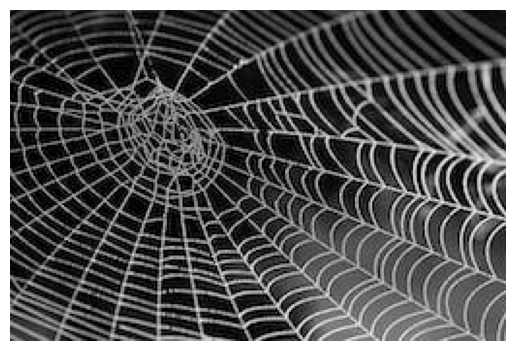

In [5]:
device = 'cuda'

def download_image(url):
    imgb = fc.urlread(url, decode=False)
    return torchvision.io.decode_image(torch.tensor(list(imgb), dtype=torch.uint8)).float()/255.
url = "https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?w=256"
style_im = download_image(url).to(device)
show_image(style_im);

In [6]:
vgg16 = timm.create_model('vgg16', pretrained=True).to(device).features
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def calc_features(imgs, target_layers=[18, 25]):
    x = normalize(imgs)
    feats = []
    for i, layer in enumerate(vgg16[:max(target_layers)+1]):
        x = layer(x)
        if i in target_layers:
            feats.append(x.clone())
    return feats

def calc_gram(style_img, target_layers=(1, 6, 18, 25)):
    '''
    get feature maps of desired style
    the correlation matrix is scaled by H*W s.t. we consider normalized values instead of absolute values
    '''
    target_features = calc_features(style_img, target_layers)
    f = lambda x: x.reshape(-1, x.shape[-3], x.shape[-1] * x.shape[-2])
    return [(f(x) @ f(x).mT)/ x.shape[-2]*x.shape[-1] for x in target_features]

class SyleTransferLoss():
    def __init__(self, target_im, target_layers=(1, 6, 18, 25)):
        '''
        This is a loss function
        Compute target_features maps by passing the target_im (i.e. the img with the content)
        thru the cnn
        target_im: the img with the content
        target_layers: target_layers that we want to use to compute the content loss
        now instead of targetting the activation maps themselves, we target the gram matrix
        of target image.
        '''
        self.target_im = target_im
        self.target_layers = target_layers
        with torch.no_grad():
            self.target_features = calc_gram(target_im, self.target_layers)

    def __call__(self, input_im):
        ''' computes perceptual loss '''
        features = calc_gram(input_im, self.target_layers)
        return sum([(feat - targ).pow(2).mean() for feat, targ in zip(features, self.target_features)])

model.safetensors:   0%|          | 0.00/553M [00:00<?, ?B/s]

In [7]:
num_channels = 4
hidden_n = 8

def make_grids(n, size=128):
    return torch.zeros(n, num_channels, size, size).to(device)

# Hard-coded filters
def get_filters():
    return torch.stack([
        torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]]),
        torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]),
        torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]).T,
        torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])]).to(device)

In [8]:
def perchannel_conv(x, filters):
    '''
    Recalling that the
    Applies each filter to each channel of the input grid
    filters: [filters_number, h, w]
    '''
    batch_size, n_channels, grid_height, grid_width = x.shape
    y = x.reshape(batch_size * n_channels, 1, grid_height, grid_width)
    y = F.pad(y, [1, 1, 1, 1], 'circular')
    # circular pad s.t. border pixels are conditioned on other-side pixes
    y = F.conv2d(y, filters[:,None])
    return y.reshape(batch_size, -1, grid_height, grid_width)

In [9]:
class SimpleCellularAutomata(nn.Module):
    def __init__(self, zero_w2=True):
        super().__init__()
        self.n_channels = 4
        self.w1 = nn.Conv2d(self.n_channels*4, hidden_n, 1)
        self.relu = nn.ReLU()
        self.w2 = nn.Conv2d(hidden_n, self.n_channels, 1, bias=False)
        self.filters = get_filters()
        if zero_w2:
            self.w2.weight.data.zero_()

    def forward(self, x, update_rate=.5):
        y = perchannel_conv(x, self.filters) # preprocess img
        y = self.w2(self.relu(self.w1(y))) # compute new values for all pixels
        b, c, h, w = y.shape
        # randomly select which pixel to update
        update_mask = (torch.rand(b,1,h,w).to(x.device)+update_rate).floor()
        return x + y * update_mask # y is how much to change pixel x!

    def to_rgb(self, x):
        return x[...,:3,:,:]+.5 # remove last channel and add 0.5 to the whole image

In [10]:
# dummy dataset:
class LengthDataset():
    # pyt datasets standard
    def __init__(self, length=1):
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return 0,0

def get_dummy_dls(length=100):
    return DataLoaders(DataLoader(LengthDataset(length), batch_size=1),
                       DataLoader(LengthDataset(1), batch_size=1))

In [11]:
class NCAProgressCB(ProgressCB):
    # for plotting
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if not (hasattr(learn, 'metrics') and learn.training): return
        self.losses.append(learn.loss.item())
        mbar = self.mbar
        if not hasattr(mbar, 'graph_fig'):
            mbar.graph_fig, mbar.graph_axs = plt.subplots(1, 2, figsize=(12, 3.5))
            mbar.graph_out = display(mbar.graph_fig, display_id=True)

        # Update preview image every 64 iters
        if (len(self.losses))%64 != 10: return

        # Plot losses:
        mbar.graph_axs[0].clear()
        mbar.graph_axs[0].plot(self.losses, '.', alpha=0.3)
        mbar.graph_axs[0].set_yscale('log')
        mbar.graph_axs[0].set_ylim(tensor(self.losses).min(), self.losses[0])
        # log scale + clipping cuz otherwise bad visualization

        # Show preview images:
        rgb = learn.model.to_rgb(learn.preds.detach()).clip(0, 1)
        show_image(torchvision.utils.make_grid(rgb), ax=mbar.graph_axs[1])

        # Update graph
        mbar.graph_out.update(mbar.graph_fig)

In [12]:
class NCACB(TrainCB):
    order = DeviceCB.order+1
    def __init__(self, cellular_automata, style_img, style_loss_scale = .1,
                size = 256, step_n_min=32, step_n_max = 96):
        fc.store_attr()
        with torch.no_grad():
            # pool of 256 grids. Each grid is 0 initalized, they act as observations/dataset
            self.pool = make_grids(256, size=size)

    def get_loss(self, learn):
        '''computes loss func using learn.loss_func that was set into Learner
        style_loss to match style img
        '''
        #import pdb; pdb.set_trace()
        style_loss = learn.loss_func(learn.model.to_rgb(learn.preds)) # compute loss over rgb predictions
        # to avoid values from going out of bounds due to the large number of steps
        overflow_loss = (learn.preds - learn.preds.clamp(-1., 1.)).abs().sum() # teach clamping
        learn.loss = overflow_loss + style_loss * self.style_loss_scale

    def predict(self, learn):
        # pick some random sample from pool of grids
        batch_idx = torch.randint(0, len(self.pool), (4,)) # low, high, output size
        x = self.pool[batch_idx]

        # occasionally zero out some samples
        if torch.randint(8, (1,)) < 1: # with probability 1/8 reset first el of batch
            x[:1] = make_grids(1, size=self.size)

        # pick a random number of steps, accumulating gradent for that number of steps
        n_steps = torch.randint(self.step_n_min, self.step_n_max, (1,))
        for _ in range(n_steps):
            x = learn.model(x) # apply the model

        # put back outputs in the pool for the next round of training
        with torch.no_grad():
            self.pool[batch_idx] = x

        # store predictions in model
        learn.preds =  x

    def backward(self, learn):
        # import pdb; pdb.set_trace()
        learn.loss.backward()
        # Gradient normalization:
        # if grads very large/small, normalize them/scale them to good values
        for p in learn.model.parameters():
            p.grad /= (p.grad.norm() + 1e-8)

In [13]:
model =  SimpleCellularAutomata().to(device)
cbs = [NCACB(model, style_im), NCAProgressCB(), MetricCB()]
style_loss = SyleTransferLoss(style_im)

learn = Learner(model, get_dummy_dls(1200), style_loss,
                lr=1e-3, cbs=cbs, opt_func=torch.optim.Adam)

loss,epoch,train
7722324891533312.000,0,train
97586696.000,0,eval


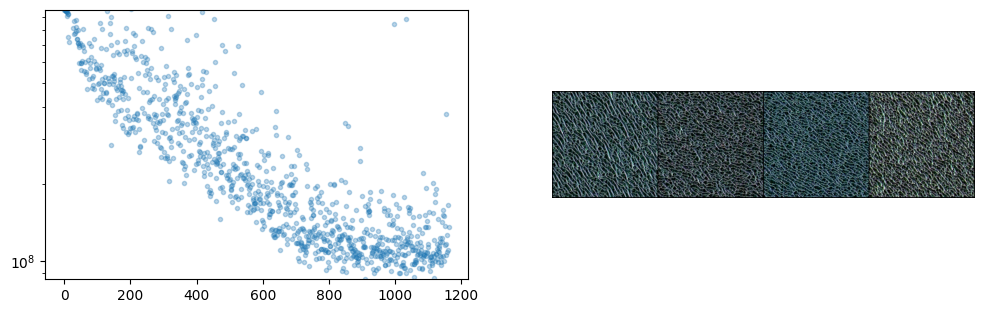

In [14]:
learn.fit(1)

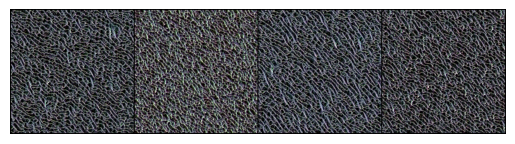

In [15]:
# Check out the final batch:
rgb = model.to_rgb(learn.preds.detach())
rgb = torchvision.utils.make_grid(rgb)
show_image(rgb.clip(0, 1));

In [16]:
# Apply a numbe of times to a random initial starting grid:
images = []
x = torch.randn(1, num_channels, 128, 128).to(device) * 0.1
for i in range(900):
    x = model(x)
    if i%100==0:
        images.append(model.to_rgb(x)[0].clip(0, 1))

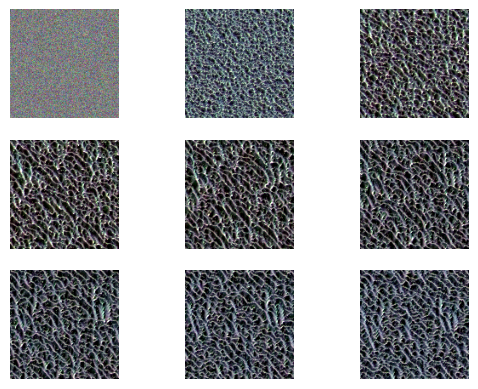

In [31]:
data = [img.cpu().detach().permute(1, 2, 0) for img in images[-9:]]
showImgGroup(data, (3,3))